In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo, TimeDelta
from statsmodels.tsa.stattools import adfuller

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst_efd_client import EfdClient
from tqdm import tqdm
from datetime import datetime
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
#timestep=0.02
from scipy.signal import find_peaks
def get_freq_psd(vals,timestep):
    meanval=np.mean(vals)
    signal= vals - meanval
    N=len(signal)
    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2
    frequencies = np.fft.rfftfreq(N, timestep)
    return(frequencies, psd)
def get_ft_peaks(vals, timestep=0.02):
    
    freq, psd = get_freq_psd(vals, 0.02)
    peak_indicies = find_peaks(psd/np.median(psd), height=10)[0]
    return freq[peak_indicies], (psd/np.median(psd))[peak_indicies]
def loop_over_hp(timestamp, client):
    df_m1m3_hp_0=getEfdData(client,"lsst.sal.MTM1M3.hardpointActuatorData",  
                        begin=timestamp, 
                        end=timestamp, 
                        prePadding=1, 
                        postPadding=4)
    freqs=[]
    actuators=[]
    strengths=[]
    maxforce=[]
    for i in range(6):
        
        vals=df_m1m3_hp_0[f'measuredForce{i}'] - np.median(df_m1m3_hp_0[f'measuredForce{i}'])
        freq, psd=get_ft_peaks(vals)
        for j,k in  enumerate(freq):
            strengths.append(j)
            freqs.append(k)
            actuators.append(i)
            maxforce.append(max(abs(vals), key=abs))
            
    return pd.DataFrame({"actuator":actuators,"freq":freqs, "strength":strengths, "maxforce":maxforce})

In [ ]:
max?

Docstring:
max(iterable, *[, default=obj, key=func]) -> value
max(arg1, arg2, *args, *[, key=func]) -> value

With a single iterable argument, return its biggest item. The
default keyword-only argument specifies an object to return if
the provided iterable is empty.
With two or more arguments, return the largest argument.
Type:      builtin_function_or_method


In [128]:
client = makeEfdClient()

In [129]:
events_frame=pd.read_csv("../data/230711_combined_events.csv")

In [130]:
timestamp=Time(events_frame["times"][0]-2, format="unix")
df_m1m3_hp_0=getEfdData(client,"lsst.sal.MTM1M3.hardpointActuatorData",  
                        begin=timestamp, 
                        end=timestamp, 
                        prePadding=1, 
                        postPadding=4)


In [131]:
sel.sum()

60

In [132]:
len(events_frame)

196

In [133]:
peak_frames=[]
sel=(abs(events_frame["times"] - Time(datetime(2023,6,28,8)).unix).values > 60 * 60 * 24)
for i,time in tqdm(enumerate(events_frame["times"][sel])):
        timestamp=Time(time-2, format="unix")
        peak_frame=loop_over_hp(timestamp, client)
        peak_frame["day_obs"]=events_frame["day_obs"]
        peak_frame["seq_num"]=events_frame["seq_num"]
        peak_frames.append(peak_frame)

50it [00:20,  2.41it/s]


In [134]:
allframe=pd.concat(peak_frames)

Text(0.5, 0.98, '50 events peaks of event psd\nnotable frequencies 0.3, 5.8, 13.6 hz')

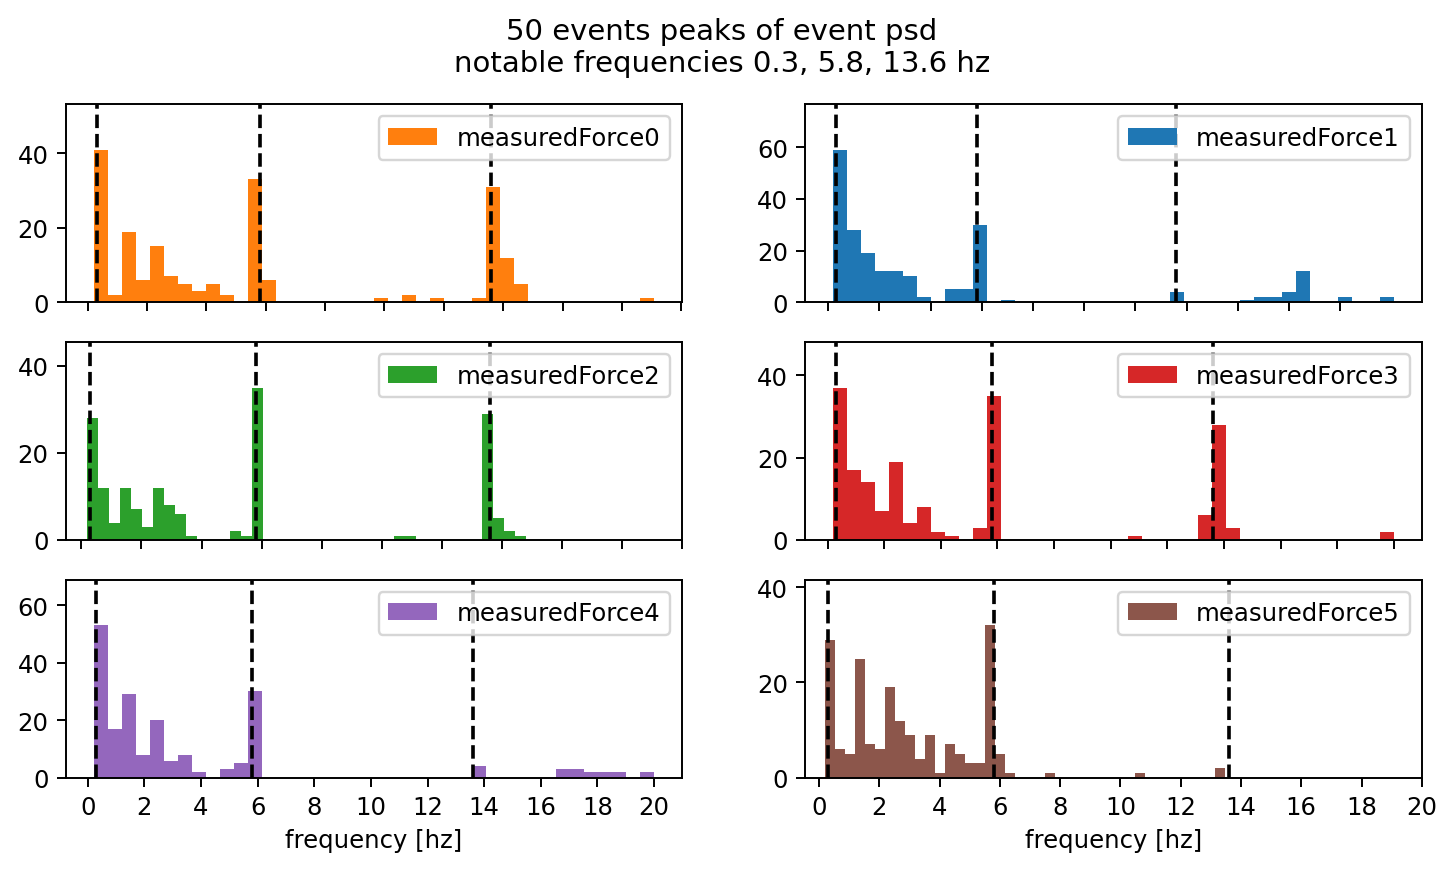

In [173]:
fig,axs=plt.subplots(3,2, dpi=175, figsize=(10,5))
color_list=["tab:orange","tab:blue","tab:green","tab:red","tab:purple","tab:brown"]
for i in np.arange(6):
    ax=axs[floor(i/2),i%2]
    sel=(allframe["actuator"]==i)
    bins=np.arange(0,21,0.5)
    hist=ax.hist(allframe["freq"][sel], bins=40, 
            color=color_list[i], label=f'measuredForce{i}')
    #ax.set_yscale('log')
    
    ax.legend()
    ax.set_ylim(0,max(hist[0]) *1.3)
    ax.set_xticks(np.arange(0,21,2))
    ax.axvline(0.3, c="k", ls="dashed")
    ax.axvline(5.8, c="k", ls="dashed")
    ax.axvline(13.6, c="k", ls="dashed")

    if floor(i/2) !=2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("frequency [hz]")
plt.suptitle("50 events peaks of event psd\nnotable frequencies 0.3, 5.8, 13.6 hz")


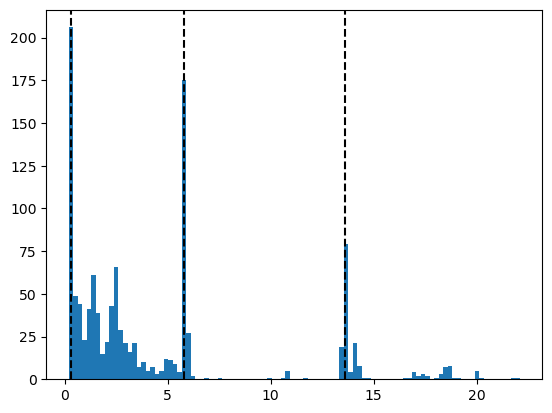

In [170]:
_=plt.hist(allframe["freq"], bins=100)
plt.axvline(0.3, c="k", ls="dashed")
plt.axvline(5.8, c="k", ls="dashed")
plt.axvline(13.6, c="k", ls="dashed")


Text(0.5, 0.98, 'Max Delta force during event\nonly for events where psd peak > 4hz')

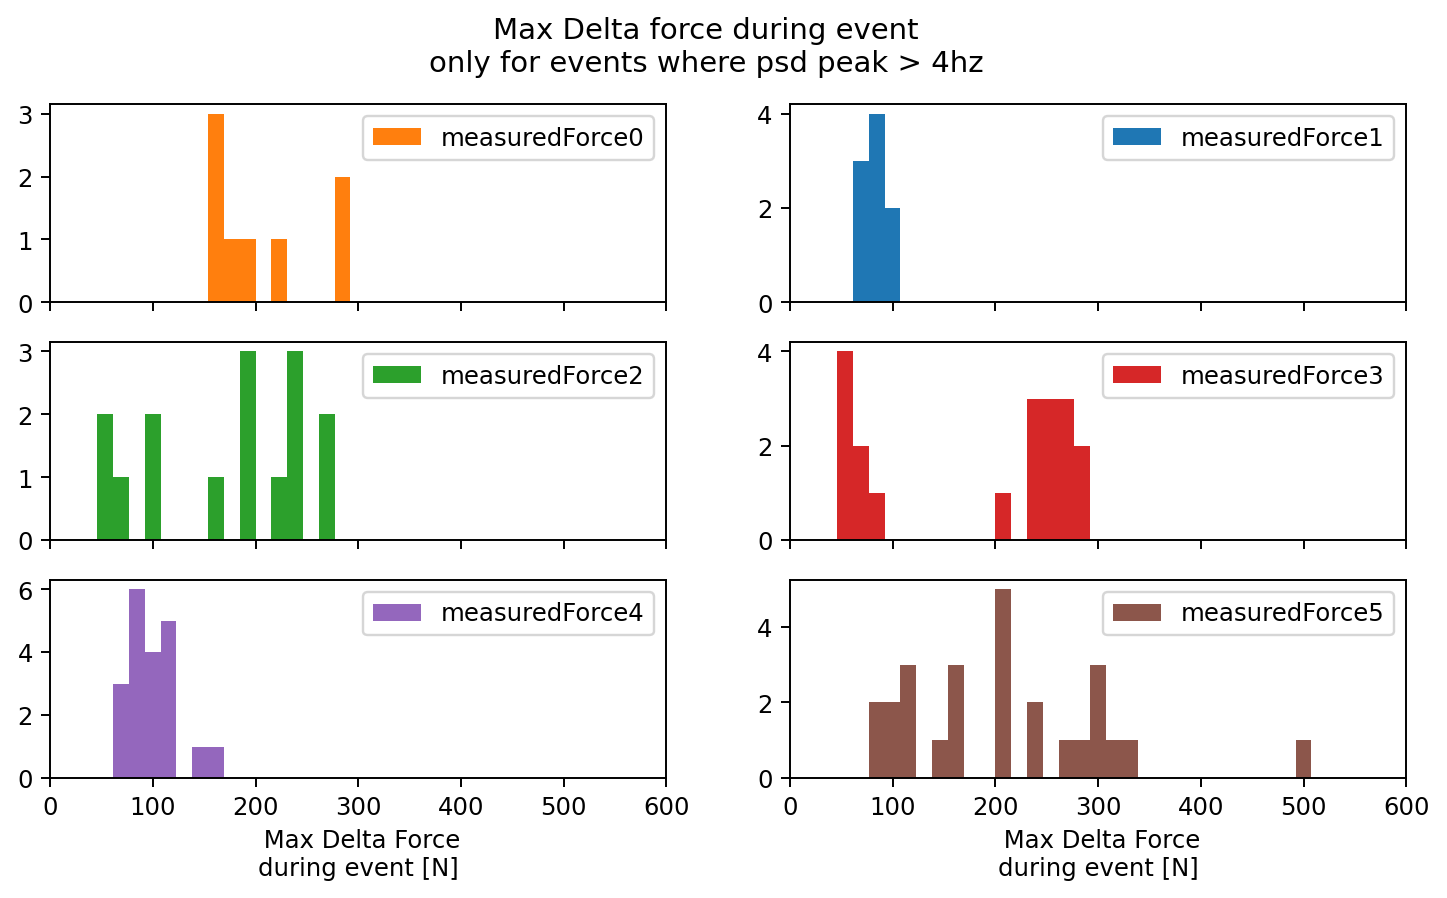

In [147]:
fig,axs=plt.subplots(3,2, dpi=175, figsize=(10,5))
color_list=["tab:orange","tab:blue","tab:green","tab:red","tab:purple","tab:brown"]
for i in np.arange(6):
    ax=axs[floor(i/2),i%2]
    sel=(allframe["actuator"]==i) & (allframe["freq"] > 4)
    _,indxs=np.unique(allframe[["seq_num"]][sel], return_index=True)
    subframe=allframe["maxforce"][sel].iloc[indxs]
    bins=np.linspace(0,600,40)
    ax.hist(subframe, bins=bins, 
            color=color_list[i], label=f'measuredForce{i}')
    #ax.set_yscale('log')
    
    ax.legend()
    ax.set_xlim(0,600)
    #ax.set_xticks(np.arange(0,21,2))
    if floor(i/2) !=2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel(" Max Delta Force\nduring event [N]")
plt.suptitle("Max Delta force during event\nonly for events where psd peak > 4hz")

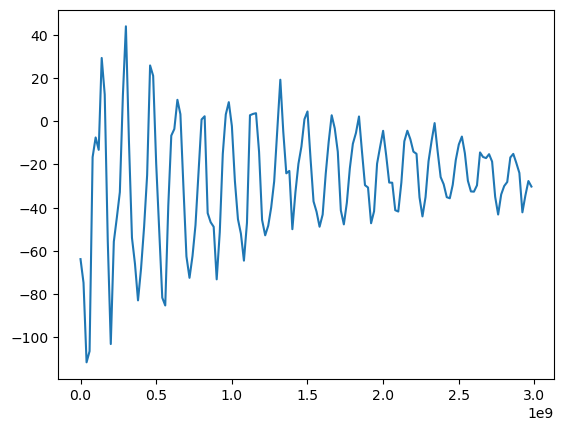

In [11]:
plt.plot(df_m1m3_hp_0.index-df_m1m3_hp_0.index.min(),df_m1m3_hp_0["measuredForce0"])

In [53]:
i=1
vals=(df_m1m3_hp_0[f'measuredForce{i}'] - np.median(df_m1m3_hp_0[f'measuredForce{i}'])).values
freq, psd=get_freq_psd(vals, 0.02)

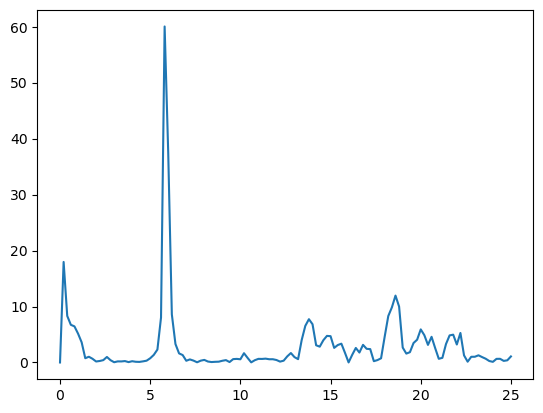

In [54]:
plt.plot(freq, psd/np.median(psd))